In [1]:
import pints
import pints.toy as toy
import pints.toy.stochastic
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

In [38]:
import os

__file = r"C:\Users\Victor\Desktop\disertation_2022\background"

my_path = os.path.abspath(__file)

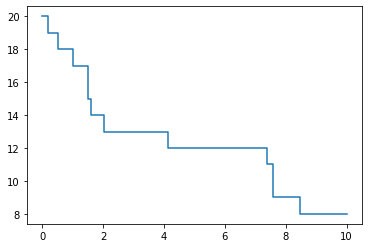

In [6]:
np.random.seed(0)

# Load a forward model
model = toy.stochastic.DegradationModel()

# Create some toy data
real_parameters = model.suggested_parameters()
times = np.linspace(0, 10, 100)

values = model.simulate(real_parameters, times)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)
# Create a uniform prior parameter
log_prior = pints.UniformLogPrior([0.0], [0.3])
# Set the error measure to be used to compare simulated to observed data
error_measure = pints.RootMeanSquaredError(problem)

plt.step(times, values)
plt.show()

In [39]:
from math import comb

n_0 = 20

# Probability for one data point
def compute_prob(n, t, k):
    exp_term = np.exp(-k * n * t)
    comb_term = comb(n_0, int(n)) 
    t_term = (1 - np.exp(-k * t)) 
    return exp_term * comb_term * (t_term ** (n_0 - n))

# Probability for multiple data points
def prob_gen(data, times, k):
    all_prob = 1.0
    for i in range(len(data)):
        computed_prob = compute_prob(data[i][0], times[i], k)
        all_prob *= computed_prob
    return all_prob


# Compute integral
from scipy import integrate

func = lambda x : prob_gen(values, times, x)
int_val = integrate.quad(func, 0.01, 0.3)
print("likelihood integrate value="+str(int_val[0]))

# True posterior
def posterior(data, times, k):
    return prob_gen(data, times, k) / int_val[0]

thetas = np.linspace(0.01, 0.3, 500)
true_prob = []
for i in range(len(thetas)):
    true_prob.append(posterior(values, times, thetas[i]))

v_func = lambda x : posterior(values, times, x)
i_val = integrate.quad(v_func, 0.01, 0.3)

print("posterior integrate value="+str(i_val[0]))

likelihood integrate value=1.2768944332797008e-81
posterior integrate value=0.9312939174188034


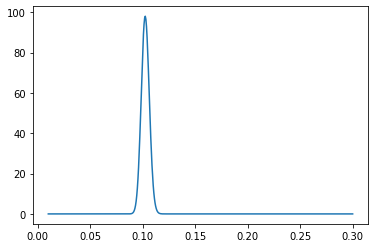

In [40]:
plt.plot(thetas, true_prob)
plt.show()

In [11]:
np.random.seed(1)
abc = pints.ABCController(error_measure, log_prior)

errors = [1, 3, 5, 7, 10]

res_samples = []

for error in errors:
    # set threshold
    abc.sampler().set_threshold(error)

    # set target number of samples
    abc.set_n_samples(1000)

    # log to screen
    abc.set_log_to_screen(True)

    print('Running...')
    samples = abc.run()
    print('Done')
    res_samples.append([x[0] for x in samples])

Running...
Using Rejection ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     348    0.00287356322    0:00.2
2     362    0.00552486188    0:00.2
3     490    0.00612244898    0:00.3
20    5564   0.0035945363     0:03.7
40    11739  0.00340744527    0:07.3
60    21659  0.002770211      0:12.5
80    26938  0.00296978246    0:15.1
100   34703  0.00288159525    0:18.9
120   42702  0.00281017283    0:22.6
140   50076  0.00279575046    0:25.9
160   57326  0.00279105467    0:29.2
180   63399  0.0028391615     0:32.1
200   68803  0.00290684999    0:34.8
220   75517  0.00291325132    0:37.7
240   82292  0.00291644388    0:40.6
260   88403  0.00294107666    0:43.3
280   93652  0.002989792      0:45.5
300   99908  0.00300276254    0:48.2
320   105910  0.00302143329    0:50.8
340   111264  0.00305579523    0:53.1
360   120914  0.00297732273    0:57.3
380   128754  0.00295136462    1:01.4
400   132741  0.00301338697    1:03.5
420   138075  0.0030418251     1:06.2
440   1435

In [22]:
res_f_samples = [[], [], [], [], []]
for i in range(5):
    res_f_samples[i].extend([x[0] for x in res_samples[i]])


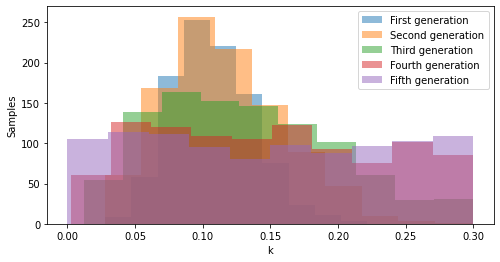

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

plt.hist(res_f_samples[0], bins=10, label='First generation', alpha=0.5)
plt.hist(res_f_samples[1], bins=10, label='Second generation', alpha=0.5)
plt.hist(res_f_samples[2], bins=10, label='Third generation', alpha=0.5)
plt.hist(res_f_samples[3], bins=10, label='Fourth generation', alpha=0.5)
plt.hist(res_f_samples[4], bins=10, label='Fifth generation', alpha=0.5)

# plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=250, label='True value', color='red')
plt.legend()
# plt.show()
plt.xlabel("k")
plt.ylabel("Samples")
# plt.savefig(my_path + './pmc_hist.pdf')
plt.show()

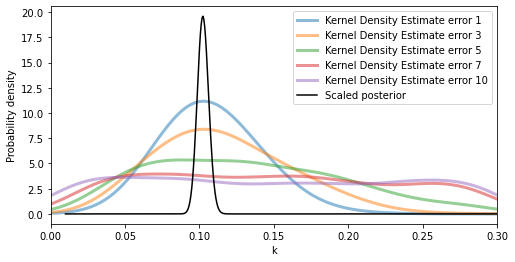

In [44]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)


fig, ax = plt.subplots(1, 1, figsize=(8, 4))

x_grid = np.linspace(0, 0.3, 100)


ax.plot(x_grid, kde_sklearn(np.array(res_f_samples[0]), x_grid, bandwidth=0.02),
            label='Kernel Density Estimate error 1', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(res_f_samples[1]), x_grid, bandwidth=0.02),
            label='Kernel Density Estimate error 3', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(res_f_samples[2]), x_grid, bandwidth=0.02),
            label='Kernel Density Estimate error 5', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(res_f_samples[3]), x_grid, bandwidth=0.02),
            label='Kernel Density Estimate error 7', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(res_f_samples[4]), x_grid, bandwidth=0.02),
            label='Kernel Density Estimate error 10', linewidth=3, alpha=0.5)

ax.plot(thetas, 0.2 * np.array(true_prob), color="black", label="Scaled posterior")
ax.set_xlim(0, 0.3)
plt.xlabel("k")
plt.ylabel("Probability density")
ax.legend()
# plt.show()
plt.savefig(my_path + './kde_errors.pdf')

In [61]:
def kl_func(y, post, kde_skl):
    part = posterior(values, times, y)
    s_part = np.exp(kde_skl.score_samples([[y]]))
    if s_part == 0 or part == 0:
        print("s_part = " + str(s_part) + ", part = " + str(part) + ", y = " + str(y))
        return np.inf
    else:
        saved = part * np.log(part / s_part)
        return saved

def kl_div(x, bandwidth, posterior, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    fun = lambda y : kl_func(y, posterior, kde_skl)
    return integrate.quad(fun, 0.03, 0.29)

def s_posterior(theta):
    return posterior(values, times, theta)


kl_fst = kl_div(np.array(res_f_samples[0]), 0.02, s_posterior)[0]
print("kl = " + str(kl_fst) + " for error 1")
kl_snd = kl_div(np.array(res_f_samples[1]), 0.02, s_posterior)[0]
print("kl = " + str(kl_snd) + " for error 3")
kl_trd = kl_div(np.array(res_f_samples[2]), 0.02, s_posterior)[0]
print("kl = " + str(kl_trd) + " for error 5")
kl_for = kl_div(np.array(res_f_samples[3]), 0.02, s_posterior)[0]
print("kl = " + str(kl_for) + " for error 7")
kl_fif = kl_div(np.array(res_f_samples[4]), 0.02, s_posterior)[0]
print("kl = " + str(kl_fif) + " for error 10")

kl = 1.561658462752255 for error 1
kl = 1.8262231210871445 for error 3
kl = 2.248459095669846 for error 5
kl = 2.567552988531549 for error 7
kl = 2.6893577493900973 for error 10
